# **Implementation of Long-Short Term Memory model**

## **Formating the data**

In [1]:
# pip install pandas, numpy, scikit-learn, tensorflow, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df_price = pd.read_pickle("hourly.pkl")
df_reserve = pd.read_pickle("reserve_features.pkl")

We filter to keep only what regards bitcoin:

In [3]:
df_eth_price = df_price[df_price['reserve_name'] == 'Wrapped Ether']
df_eth_reserve = df_reserve[df_reserve['reserve_name'] == 'Wrapped Ether']

We merge `df_eth_price` and `df_eth_reserve` on date:

In [4]:
df = pd.merge(df_eth_price, df_eth_reserve, left_on='datetime', right_on='regular_datetime')

We sort by date, remove duplicates et uninteresting variables:

In [5]:
# df = df[(df['datetime'] >= '2023-01-01') & (df['datetime'] < '2024-06-01')]

df = df.sort_values('datetime')
df = df.drop_duplicates(subset='datetime')
cols_to_drop = [
    'Unnamed: 0_x',
    'Unnamed: 0_y',
    'blockNumber',
    'timestamp_hours',
    'snapshot_timestamp',
    'timestamp',
    'outputTokenPriceUSD',
    'totalPrincipalStableDebt',
    'averageStableBorrowRate',
    'priceInEth',
    'priceInUsd',
    'reserve_decimals',
    'true_value',
    'reserve_name_x',
    'reserve_name_y',
    'regular_datetime'
]
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

We define the variables: logarithm of price of bitcoin, and logarithm of `totalATokenSupply`, `totalLiquidity`, `availableLiquidity`:

In [6]:
df['log_ETH'] = np.log(df['inputTokenPriceUSD'])

for col in ['totalATokenSupply', 'totalLiquidity', 'availableLiquidity']:
    if col in df.columns:
        df[f'log_{col}'] = np.log(df[col] + 1e-8) # to avoid log(0)

We also approximate the percent change of each variable $X_t$ as the simple differences on its log-variable, namely $\text{diff\_log\_} X_t := \log(X_t) - \log(X_{t - 1})$.

This approximation is valid because $$\text{diff\_log\_} X_t = \log\left(\frac{X_t}{X_{t - 1}}\right) \approx \frac{X_t}{X_{t - 1}} - 1 = \frac{X_t - X_{t - 1}}{X_{t - 1}}$$ since $\log(u) \approx u - 1$ when $u \approx 1$.

In [7]:
df['diff_log_ETH'] = df['log_ETH'].diff()
df['diff_log_totalATokenSupply'] = df['log_totalATokenSupply'].diff()
df['diff_log_totalLiquidity'] = df['log_totalLiquidity'].diff()
df['diff_log_availableLiquidity'] = df['log_availableLiquidity'].diff()

# Delete first line which contains NaN's because of diff()
df = df.dropna(subset=['diff_log_ETH', 'diff_log_totalATokenSupply', 'diff_log_totalLiquidity', 'diff_log_availableLiquidity'])

df[['diff_log_ETH', 'diff_log_totalATokenSupply', 'diff_log_totalLiquidity', 'diff_log_availableLiquidity']].describe()

,diff_log_ETH,diff_log_totalATokenSupply,diff_log_totalLiquidity,diff_log_availableLiquidity
count,16668.000000,16668.000000,16668.000000,16668.000000
mean,0.000045,0.000796,0.000795,0.000681
std,0.006081,0.024761,0.024768,0.038610
min,-0.103310,-0.253625,-0.253693,-0.683843
25%,-0.001999,-0.000077,-0.000081,-0.001390
50%,0.000000,0.000020,0.000017,0.000064
75%,0.002228,0.000296,0.000298,0.002265
max,0.088381,2.140974,2.140974,2.276832


In [8]:
df = df.dropna(subset=['log_ETH', 'log_totalATokenSupply', 'log_totalLiquidity', 'log_availableLiquidity'])
df = df.reset_index(drop=True)
df[['datetime', 'log_ETH', 'log_totalATokenSupply', 'log_totalLiquidity', 'log_availableLiquidity']].head()

,datetime,log_ETH,log_totalATokenSupply,log_totalLiquidity,log_availableLiquidity
0,2023-01-27 09:00:00+00:00,7.365901,1.261893,1.261893,1.109256
1,2023-01-27 10:00:00+00:00,7.363098,3.402867,3.402867,3.386088
2,2023-01-27 11:00:00+00:00,7.363098,3.527834,3.527834,3.513040
3,2023-01-27 12:00:00+00:00,7.363324,4.346562,4.346562,4.073815
4,2023-01-27 13:00:00+00:00,7.359210,4.925270,4.925270,4.647221


In [9]:
feature_cols = [
    'log_ETH', 'log_totalATokenSupply', 'log_totalLiquidity', 'log_availableLiquidity',
    'diff_log_ETH', 'diff_log_totalATokenSupply', 'diff_log_totalLiquidity', 'diff_log_availableLiquidity'
]
target_col = 'log_ETH'
df_model = df[feature_cols].copy()
df_model

,log_ETH,log_totalATokenSupply,log_totalLiquidity,log_availableLiquidity,diff_log_ETH,diff_log_totalATokenSupply,diff_log_totalLiquidity,diff_log_availableLiquidity
0,7.365901,1.261893,1.261893,1.109256,-0.002988,0.149345,0.149345,0.010310
1,7.363098,3.402867,3.402867,3.386088,-0.002803,2.140974,2.140974,2.276832
2,7.363098,3.527834,3.527834,3.513040,0.000000,0.124967,0.124967,0.126953
3,7.363324,4.346562,4.346562,4.073815,0.000226,0.818728,0.818728,0.560775
4,7.359210,4.925270,4.925270,4.647221,-0.004114,0.578708,0.578708,0.573405
...,...,...,...,...,...,...,...,...
16663,8.116175,14.369105,14.351976,12.423227,-0.002437,0.000015,0.000013,0.001227
16664,8.111354,14.369209,14.352080,12.423927,-0.004821,0.000104,0.000104,0.000700
16665,8.111354,14.368975,14.351840,12.422268,0.000000,-0.000233,-0.000240,-0.001659
16666,8.110420,14.370590,14.353481,12.433462,-0.000934,0.001615,0.001641,0.011193


We split the data chronologically: Train = 70 %, Validation = 15 %, Test = 15 % :

In [10]:
n = len(df_model)
train_size = int(0.70 * n)
val_size = int(0.15 * n)

train_df = df_model.iloc[:train_size]
val_df = df_model.iloc[train_size:train_size+val_size]
test_df = df_model.iloc[train_size+val_size:]

We normalize the features $x$ using the formula
$$x_{\text{standard}} = \frac{x - \mu_{\text{train}}}{\sigma_{\text{train}}}$$

We fit the scaler on the training set and we apply the transformation to the validation and test sets:

In [11]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_df)

val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

## **Constructing the sequences**

We create fixed-length sliding windows/sequences:

In [12]:
def create_sequences(data, window=24, horizon=1):
    X, y = [], []
    for i in range(len(data) - window - horizon + 1):
        X.append(data[i:i+window])
        y.append(data[i+window+horizon-1][0]) # 0 = log_ETH
    return np.array(X), np.array(y)

We'll start testing it with a window of size 24 hours and we predict one step ahead (`HORIZON = 1`):

In [13]:
WINDOW = 24
HORIZON = 1

X_train, y_train = create_sequences(train_scaled, WINDOW, HORIZON)
X_val, y_val = create_sequences(val_scaled, WINDOW, HORIZON)
X_test, y_test = create_sequences(test_scaled, WINDOW, HORIZON)

X_train.shape, y_train.shape

((11643, 24, 8), (11643,))

## **Constructing the LSTM model**

In [14]:
input_shape = X_train.shape[1:] # (24, 4)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dense(1) # predicts log_ETH at time t+1
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

## **Training the model**

We create an 'early stopping callback' which stops training if `val_loss` no longer improves. Then we train the model:

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.0775 - root_mean_squared_error: 0.2489 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1011
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 11

## **Evaluating the model**

We predict `log_ETH` at time $t + 1$. We add dummy columns to match the original feature shape. Finally, we invert the scaler to return to original scale.

In [16]:
y_pred_scaled = model.predict(X_test).flatten()

n_features = X_test.shape[2]
y_pred_full = np.column_stack([y_pred_scaled] + [np.zeros_like(y_pred_scaled) for _ in range(n_features - 1)])
y_true_full = np.column_stack([y_test] + [np.zeros_like(y_test) for _ in range(n_features - 1)])

y_pred_inversed = scaler.inverse_transform(y_pred_full)[:, 0]
y_true_inversed = scaler.inverse_transform(y_true_full)[:, 0]

78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step


In [17]:
rmse = np.sqrt(mean_squared_error(y_true_inversed, y_pred_inversed))
mae = mean_absolute_error(y_true_inversed, y_pred_inversed)
r2 = r2_score(y_true_inversed, y_pred_inversed)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² : {r2:.4f}")

RMSE: 0.0124
MAE: 0.0105
R² : 0.9947


Below we compare the true log-price of bitcoin with the 200 first predictions:

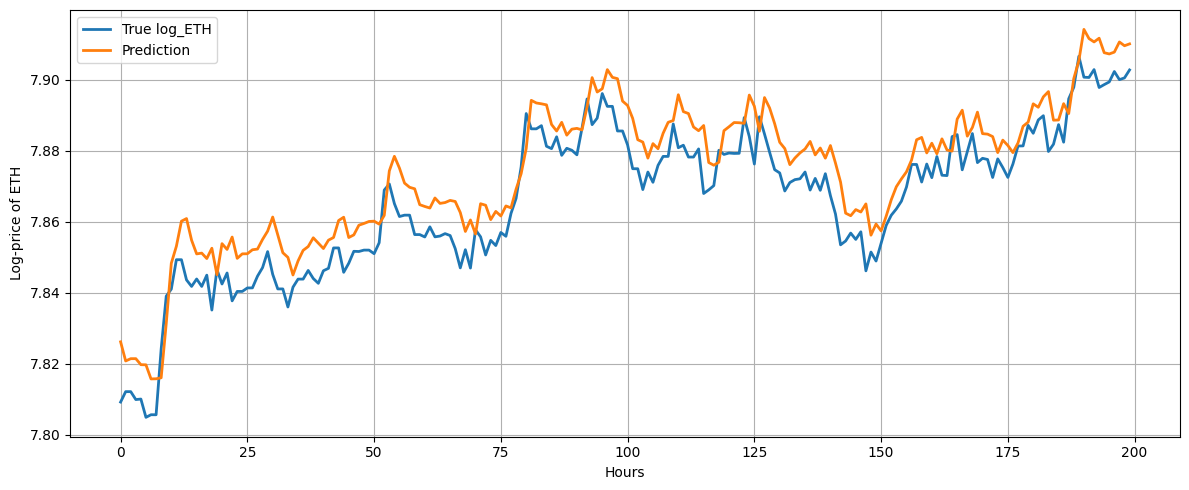

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_inversed[:200], label="True log_ETH", linewidth=2)
plt.plot(y_pred_inversed[:200], label="Prediction", linewidth=2)
plt.xlabel("Hours")
plt.ylabel("Log-price of ETH")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We compare true log-bictoin with prediction on the whole test set:

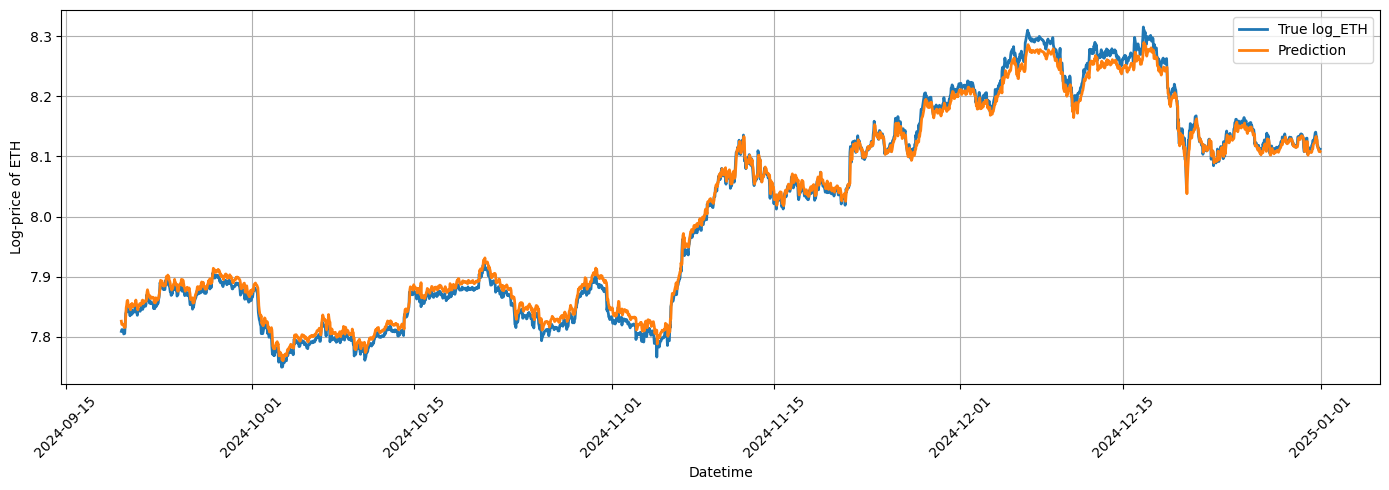

In [19]:
test_datetime = df['datetime'].iloc[train_size + val_size + WINDOW + HORIZON - 1 :
                                    train_size + val_size + WINDOW + HORIZON - 1 + len(y_true_inversed)]

plt.figure(figsize=(14, 5))
plt.plot(test_datetime, y_true_inversed, label="True log_ETH", linewidth=2)
plt.plot(test_datetime, y_pred_inversed, label="Prediction", linewidth=2)
plt.xlabel("Datetime")
plt.ylabel("Log-price of ETH")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Trying other lenghts of windows**

In [20]:
for window in [8, 10, 12, 14, 16, 24, 48, 72]:
    print(f"\n---> Testing window of length {window} hours.")

    X_train, y_train = create_sequences(train_scaled, window)
    X_val, y_val = create_sequences(val_scaled, window)
    X_test, y_test = create_sequences(test_scaled, window)

    model = models.Sequential([
        layers.Input(shape=(window, X_train.shape[2])),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    es = callbacks.EarlyStopping(patience=5,
                                 restore_best_weights=True,
                                 monitor='val_loss')

    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=50,
              batch_size=64,
              callbacks=[es],
              verbose=0)

    y_pred_scaled = model.predict(X_test, verbose=0).flatten()

    n_features = X_test.shape[2]
    y_pred_full = np.column_stack([y_pred_scaled] + [np.zeros_like(y_pred_scaled) for _ in range(n_features - 1)])
    y_true_full = np.column_stack([y_test] + [np.zeros_like(y_test) for _ in range(n_features - 1)])
    y_pred_inversed = scaler.inverse_transform(y_pred_full)[:, 0]
    y_true_inversed = scaler.inverse_transform(y_true_full)[:, 0]

    rmse = np.sqrt(mean_squared_error(y_true_inversed, y_pred_inversed))
    mae = mean_absolute_error(y_true_inversed, y_pred_inversed)
    r2 = r2_score(y_true_inversed, y_pred_inversed)

    print(f"window of {window} hours --- RMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")


---> Testing window of length 8 hours.
window of 8 hours --- RMSE = 0.0274, MAE = 0.0207, R² = 0.9741

---> Testing window of length 10 hours.
window of 10 hours --- RMSE = 0.0332, MAE = 0.0248, R² = 0.9619

---> Testing window of length 12 hours.
window of 12 hours --- RMSE = 0.0318, MAE = 0.0244, R² = 0.9649

---> Testing window of length 14 hours.
window of 14 hours --- RMSE = 0.0259, MAE = 0.0197, R² = 0.9768

---> Testing window of length 16 hours.
window of 16 hours --- RMSE = 0.0335, MAE = 0.0267, R² = 0.9612

---> Testing window of length 24 hours.
window of 24 hours --- RMSE = 0.0291, MAE = 0.0225, R² = 0.9707

---> Testing window of length 48 hours.
window of 48 hours --- RMSE = 0.0279, MAE = 0.0216, R² = 0.9729

---> Testing window of length 72 hours.
window of 72 hours --- RMSE = 0.0228, MAE = 0.0167, R² = 0.9820
